<a href="https://colab.research.google.com/github/Waqasii/AttendanceManagementSystem/blob/main/FeatureSelectionUsingGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Necessary Imports

In [100]:
import time
import random
import pandas as pd
import numpy as np
import copy
import math
import tensorflow
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load the data

In [101]:
dataframe = pd.read_csv('sample_data/bank-additional-full.csv', sep=";")
GLOBAL_ACCURACY = 0.80
# print(dataframe.shape)
# print(dataframe.columns)
# dataframe = pd.get_dummies(dataframe)
# print(dataframe.shape)
# print(dataframe.columns)

## **Noise**
### **Add 5 dummy colm** 

In [102]:
# Generate random values for each dummy column
dummy1 = np.random.rand(dataframe.shape[0])
dummy2 = np.random.rand(dataframe.shape[0])
dummy3 = np.random.rand(dataframe.shape[0])
dummy4 = np.random.rand(dataframe.shape[0])
dummy5 = np.random.rand(dataframe.shape[0])

# Create a DataFrame with the dummy columns
dummy_df = pd.DataFrame({
    'dummy1': dummy1,
    'dummy2': dummy2,
    'dummy3': dummy3,
    'dummy4': dummy4,
    'dummy5': dummy5
})

# Concatenate the original DataFrame with the dummy DataFrame
dataframe = pd.concat([dataframe, dummy_df], axis=1)

In [103]:
def convert_to_numeric(dataframe):
    # Loop over all columns in the dataframe
    for col_name in dataframe.columns:
        # Check if the column is categorical
        if dataframe[col_name].dtype.name == 'category':
            # Convert the categorical column to numeric using cat.codes
            dataframe[col_name] = dataframe[col_name].cat.codes
        # Check if the column is of type 'object'
        elif dataframe[col_name].dtype.name == 'object':
            # Convert the 'object' column to numeric using factorize
            dataframe[col_name] = pd.factorize(dataframe[col_name])[0]
    return dataframe




# GETTER FOR UNIQUE VALUES
def get_uniques(dataframe):
    for feature in dataframe.columns:

        print(f"Feature {feature}: \n{list(pd.Series(dataframe[feature]).unique())}")



# Encode the categorical variables using One-Hot Encoding
dataframe = pd.get_dummies(dataframe, columns=["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"])


# dataframe = convert_to_numeric(dataframe)
# # Remove any rows with missing values
# dataframe = dataframe.dropna()

# get_uniques(dataframe)

print(dataframe.isnull().sum())

age                     0
duration                0
campaign                0
pdays                   0
previous                0
                       ..
day_of_week_tue         0
day_of_week_wed         0
poutcome_failure        0
poutcome_nonexistent    0
poutcome_success        0
Length: 69, dtype: int64


In [104]:
# GETTER FOR MISSING VALUES
def get_missing_values(dataframe):
    for col in dataframe.isnull():
        all = list()
        print(f'Feature {col}:\n\n')
        for index, instance in enumerate(dataframe.isnull()[col]):
            if instance is True:
                all.append(index)
        print(f'Missing instances: {all}')
        print('Number of missing instances: ', len(all))

get_missing_values(dataframe)

Feature age:


Missing instances: []
Number of missing instances:  0
Feature duration:


Missing instances: []
Number of missing instances:  0
Feature campaign:


Missing instances: []
Number of missing instances:  0
Feature pdays:


Missing instances: []
Number of missing instances:  0
Feature previous:


Missing instances: []
Number of missing instances:  0
Feature emp.var.rate:


Missing instances: []
Number of missing instances:  0
Feature cons.price.idx:


Missing instances: []
Number of missing instances:  0
Feature cons.conf.idx:


Missing instances: []
Number of missing instances:  0
Feature euribor3m:


Missing instances: []
Number of missing instances:  0
Feature nr.employed:


Missing instances: []
Number of missing instances:  0
Feature y:


Missing instances: []
Number of missing instances:  0
Feature dummy1:


Missing instances: []
Number of missing instances:  0
Feature dummy2:


Missing instances: []
Number of missing instances:  0
Feature dummy3:


Missing instances: [

# Analyse the class Inbalancing

Class Distribution:
no     36548
yes     4640
Name: y, dtype: int64
no     88.734583
yes    11.265417
Name: y, dtype: float64


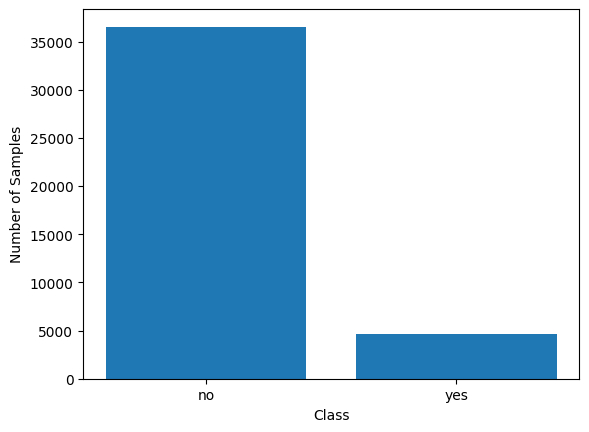

In [105]:
import pandas as pd
import matplotlib.pyplot as plt


# Count the number of samples in each class
class_counts = dataframe['y'].value_counts()

# Calculate the percentage of samples in each class
class_percents = class_counts / len(dataframe) * 100

# Print the class distribution
print('Class Distribution:')
print(class_counts)
print(class_percents)

# Plot a bar chart of the class distribution
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

## Balanace Dataset - DownSampling


no     4640
yes    4640
Name: y, dtype: int64
Class Distribution:
no     4640
yes    4640
Name: y, dtype: int64
no     50.0
yes    50.0
Name: y, dtype: float64


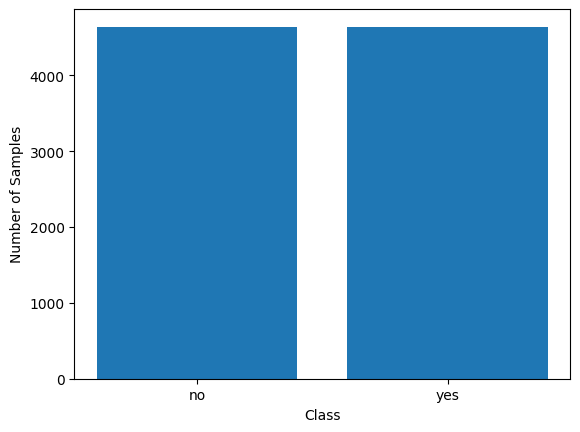

In [106]:
from sklearn.utils import resample

# Assuming your imbalanced dataset is stored in a pandas dataframe called 'df'

# Separate majority and minority classes
df_majority = dataframe[dataframe.y=='no']
df_minority = dataframe[dataframe.y=='yes']
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority), # match number of samples in minority class
                                 random_state=42)  # reproducible results
 
# Combine minority class with downsampled majority class
dataframe = pd.concat([df_majority_downsampled, df_minority])
 
# Check new class distribution
print(dataframe['y'].value_counts())




# Count the number of samples in each class
class_counts = dataframe['y'].value_counts()

# Calculate the percentage of samples in each class
class_percents = class_counts / len(dataframe) * 100

# Print the class distribution
print('Class Distribution:')
print(class_counts)
print(class_percents)

# Plot a bar chart of the class distribution
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

### **Define functions for calculating metrics**

In [107]:
from keras import backend as K

def recall_fun(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_fun(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_fun(y_true, y_pred):
    precision = precision_fun(y_true, y_pred)
    recall = recall_fun(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### **Define functions to be used for the Genetic Algorithm**

In [108]:
def generate_dataframes_for_training(dataframe, split_frac=0.8):
    """
    Generates training and testing dataframes from a complete dataframe, according to the split_frac parameter
    """
    
    train_data = dataframe.sample(frac=split_frac, random_state=314)
    test_data = dataframe.drop(train_data.index)
    
    X_train = train_data.loc[:, train_data.columns != 'y']
    X_test = test_data.loc[:, test_data.columns != 'y']
    y_train = train_data.loc[:, train_data.columns == 'y']
    y_test = test_data.loc[:, test_data.columns == 'y']

    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [109]:
def get_n_individual(counter, population):
    """
    If counter is 0, return the individual with the highest prob
    If counter is 1, return the second individual with the highest prob
    If counter is 2, return the third individual withthe highest prob
    """
    index = counter + 1
    probabilities = [ind[1] for ind in population]
    sorted_probs = sorted(probabilities, key=float)
    max_prob = probabilities[-index]
    max_individual = [ind[0] for ind in population if ind[1] == max_prob][0]
    
    return max_individual

In [110]:
def generate_random_individuals(num_individuals, num_features, max_features=None, verbose=False):
    """
    Randomly generates individuals

    The number of individuals to generate is given by the num_individuals parameter
    The length of each individual is equal to the num_features parameter
    The maximum number of active features for every individual is given by the max_features parameter
    """
    if verbose: print('GENERATING RANDOM INDIVIDUALS.... ')
        
    individuals = list()
    
    for _ in range(num_individuals):
        individual = ''
        for col in range(num_features):
            # For each char in the individual, a 1 or a 0 is randomly generated
            if individual.count('1') == max_features:
                individual += '0'
                continue
                
            individual += str(random.randint(0, 1))
            
        if verbose: print(f'Genrated a new indivudal: {individual}')
        individuals.append(individual)
        
    if verbose: print(f'Generated list of {num_individuals} individuals: {individuals}')
        
    return individuals


# individuals_temp = generate_random_individuals(10, 20, 10)
# print(individuals_temp)

In [111]:
def create_model(X, verbose=False):
    """
    X: training dataset to be used. Its shape is used to set the input shape for the model.
    """
    
    model = Sequential()
    
    model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    if verbose: print('MODEL SUMMARY: \n')
    if verbose: print(model.summary())
    
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model



def get_weights(population):
    """
    Calculate weights from the population filled with the accuracies
    """
    total_accuracies = 0
    new_population = []
    
    # Get the sum of all accuracies of the population
    for individual in population:
        total_accuracies += individual[1]
        
    # For each individual, calculate its weight by dividing its accuracy by the overall sum calculated above
    for individual in population:
        weight = individual[1]/total_accuracies
        # Store the individual and its weight in the final population list
        new_population.append((individual[0], float(weight*100)))
        
    return new_population



def get_fitness_func(individual, dataframe, verbose=False):
    """
    Calculate accuracy for the individual passed as parameter.
    Both the dataframe and the y_data parameters are used for training and evaluating the model.
    """
    if verbose: print('Calculating accuracy for individual ', individual)
    
    # generate_dataframes_for_training() function splits a given dataset into training and test data, 
    # and separates labels and rest of features
    X_train, X_test, y_train, y_test = generate_dataframes_for_training(dataframe)
    
    X_train = X_train.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]
    X_test = X_test.loc[:, [True if individual[i] == '1' else False for i in range(len(individual))]]    
    
    model = create_model(X_train, individual)
    

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.fit_transform(y_test)
    # X_train = np.asarray(X_train).astype(np.float64)
    # X_test = np.asarray(X_test).astype(np.float64)
    # y_train = np.asarray(y_train).astype(np.float64)
    # y_test = np.asarray(y_test).astype(np.float64)
    
    model.fit(X_train, y_train, epochs=100, verbose=1 if verbose else 0)
    
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred.round())
    if verbose: print(f"Accuracy for the classifier trained for individual {individual}: ", accuracy)
    
    return accuracy



def fill_population(individuals, dataframe, verbose=False):
    """
    Fills the population list with individuals and their weights
    """
    population = list()
    
    for individual in individuals:
        
        # Get the value of the fitness function (accuracy of the model)
        if verbose: print(f'Calculating fitness function value for individual {individual}')
        accuracy = get_fitness_func(individual, dataframe, verbose)
        
        # Check that the value is not the goal state (in this case, an accuracy of 80% is a terminal state)
        if float(accuracy) > GLOBAL_ACCURACY:
            if verbose: print(f'Goal state found for individual {individual}')
            return individual
            
        individual_complete = (individual, accuracy)
        population.append(individual_complete)
        
    # The final population list is created, which contains each individual together with its weight
    # (weights will be used in the reproduction step)
    new_population = get_weights(population)
    if verbose: print(f'Generated population list (with weights): {new_population}')
    
    return new_population



def choose_parents(population, counter):
    """
    From the population, weighting the probabilities of an individual being chosen via the fitness
    function, takes randomly two individual to reproduce
    Population is a list of tuples, where the first element is the individual and the second
    one is the probability associated to it.
    To avoid generating repeated individuals, 'counter' parameter is used to pick parents in different ways, thus
    generating different individuals
    """
    # Pick random parent Number 1 and Number 2
    # (get_n_individual() function randomly picks an individual following the distribution of the weights)
    if counter == 0:        
        parent_1 = get_n_individual(0, population)        
        parent_2 = get_n_individual(1, population)
    elif counter == 1:
        parent_1 = get_n_individual(0, population)        
        parent_2 = get_n_individual(2, population)
        
    else:
        probabilities = (individual[1] for individual in population)
        individuals = [individual[0] for individual in population]
        parent_1, parent_2 = random.choices(individuals, weights=probabilities, k=2)
    
    return [parent_1, parent_2]


  
def mutate(child, prob=0.1):
    """
    Randomly mutates an individual according to the probability given by prob parameter
    """
    new_child = copy.deepcopy(child)
    for i, char in enumerate(new_child):
        if random.random() < prob:
            new_value = '1' if char == '0' else '0'
            new_child = new_child[:i] + new_value + new_child[i+1:]
    
    return new_child


  
def reproduce(individual_1, individual_2):
    """
    Takes 2 individuals, and combines their information based on a
    randomly chosen crosspoint.
    Each reproduction returns 2 new individuals
    """ 
    # Randomly generate a integer between 1 and the length of the individuals minus one, which will be the crosspoint
    crosspoint = random.randint(1, len(individual_1)-1)
    child_1 = individual_1[:crosspoint] + individual_2[crosspoint:]
    child_2 = individual_2[:crosspoint] + individual_1[crosspoint:]
    child_1, child_2 = mutate(child_1), mutate(child_2)
 
    return [child_1, child_2]


  
def generation_ahead(population, verbose=False):
    """
    Reproduces all the steps for choosing parents and making 
    childs, which means creating a new generation to iterate with
    """
    new_population = list()
    
    for _ in range(int(len(population)//2)):      
        # According to the weights calculated before, choose a set of parents to reproduce
        parents = choose_parents(population, counter=_)
        if verbose: print(f'Parents chosen: {parents}')
          
        # Reproduce the pair of individuals chose above to generate two new individuals
        childs = reproduce(parents[0], parents[1])
        if verbose: print(f'Generated children: {childs}\n')
        new_population += childs
        
    return new_population



def main_loop(ind_num, dataframe, max_iter=2, verbose=True):
    """
    Performs all the steps of the Genetic Algorithm
    1. Generate random population
    2. Fill population with the weights of each individual
    3. Check if the goal state is reached
    4. Reproduce the population, and create a new generation
    5. Repeat process until termination condition is met
    """
    print('Number of features:', dataframe.shape[1] )
    # Generate individuals (returns a list of strings, where each str represents an individual)
    individuals = generate_random_individuals(ind_num, dataframe.shape[1]-1, 30, verbose)
    
    # Returns a list of tuples, where each tuple represents an individual and its weight
    population = fill_population(individuals, dataframe, verbose)
    
    # Check if a goal state is reached
    # When goal state is reached, fill_population() function returns a str, otherwise continue
    if isinstance(population, str):
        return population
        
    # Reproduce current generation to generate a better new one
    new_generation = generation_ahead(population, verbose)
    
    # After the new generation is generated, the loop goes on until a solution is found or until the maximum number of
    # iterations are reached
    iteration_count = 0
    while iteration_count < max_iter:
        if verbose: print(f'\n\n\nITERATION NUMBER {iteration_count+1} (Iteration max = {max_iter+1})\n\n\n')
        population = fill_population(new_generation, dataframe, verbose)
        
        # Check if a goal state is reached
        if isinstance(population, str):
            break
        
        new_generation = generation_ahead(population, verbose)   
        iteration_count += 1
        
    return population


### **Create and train the model with the complete dataset**


In [112]:


# Create the model
model = Sequential()
model.add(Dense(64, input_dim=dataframe.shape[1]-1, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
  
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [113]:
# Generate dataframes for both training and testing
X_train, X_test, y_train, y_test = generate_dataframes_for_training(dataframe)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# test
# # Convert categorical variables to numerical variables using one-hot encoding
# X_train = pd.get_dummies(X_train)
# X_test = pd.get_dummies(X_test)
# y_train = pd.get_dummies(y_train)
# y_test = pd.get_dummies(y_test)


# X_train = np.asarray(X_train).astype('float32')
# y_train = np.asarray(y_train).astype('float32')
# X_test = np.asarray(X_test).astype('float32')
# y_test = np.asarray(y_test).astype('float32')



(7424, 68)
(1856, 68)
(7424, 1)
(1856, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [114]:
start = time.time()
model.fit(X_train, y_train, epochs=128, validation_data=(X_test, y_test), verbose=1)
print('Time elapsed for training the model with the full dataset: ', time.time() - start, ' seconds')


Epoch 1/128
232/232 [==============================] - 2s 4ms/step - loss: 12.5720 - accuracy: 0.6468
Epoch 2/128
232/232 [==============================] - 1s 4ms/step - loss: 8.1062 - accuracy: 0.6835
Epoch 3/128
232/232 [==============================] - 1s 3ms/step - loss: 6.5273 - accuracy: 0.7095
Epoch 4/128
232/232 [==============================] - 1s 2ms/step - loss: 5.7499 - accuracy: 0.7135
Epoch 5/128
232/232 [==============================] - 1s 3ms/step - loss: 4.7835 - accuracy: 0.7247
Epoch 6/128
232/232 [==============================] - 1s 3ms/step - loss: 4.1363 - accuracy: 0.7204
Epoch 7/128
232/232 [==============================] - 1s 2ms/step - loss: 3.2622 - accuracy: 0.7416
Epoch 8/128
232/232 [==============================] - 1s 3ms/step - loss: 2.8230 - accuracy: 0.7404
Epoch 9/128
232/232 [==============================] - 1s 3ms/step - loss: 2.5381 - accuracy: 0.7396
Epoch 10/128
232/232 [==============================] - 1s 2ms/step - loss: 2.2093 - accur

## Evaluation

In [115]:
from sklearn.metrics import classification_report

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")
GLOBAL_ACCURACY = accuracy

y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

print(classification_report(y_test, y_pred_classes))


58/58 [==============================] - 0s 1ms/step - loss: 0.3693 - accuracy: 0.8400
Test loss: 0.3692933917045593
Test accuracy: 0.8399784564971924
58/58 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       960
           1       0.76      0.99      0.86       896

    accuracy                           0.84      1856
   macro avg       0.87      0.84      0.84      1856
weighted avg       0.87      0.84      0.84      1856



## ***EXPERIMENT2:***
### **Create and train the model with the optimized dataset**
### **First, the relevant features must be selected by applying the GA**

In [116]:
start = time.time()
final_population = main_loop(100, dataframe, verbose=True)
print('Time elapsed for executing the recursive GA: ', time.time() - start, ' seconds')

Number of features: 69
GENERATING RANDOM INDIVIDUALS.... 
Genrated a new indivudal: 10111101110100100111101110011100000011101100100111010000000000000000
Genrated a new indivudal: 11111000111110100110001100101010100110101000001011101010010000000000
Genrated a new indivudal: 10000011010011101011100001000111000110010110001011101100111000010000
Genrated a new indivudal: 11100110111010000011111111010001011000101001110001001110000000000000
Genrated a new indivudal: 00110010001101010100010001110110011100001111011110011001100010000000
Genrated a new indivudal: 01101110011011011111100010101110010011100000001001011100100000000000
Genrated a new indivudal: 11010001101110001010000101010100100111010101011101011110100000000000
Genrated a new indivudal: 11110011101101011100111000110000001100000100010110110011100100000000
Genrated a new indivudal: 11001001110000001000110100100101101101001101110110010111110000000000
Genrated a new indivudal: 0110001001100011110000000111100110000010101010101101000111110

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


232/232 [==============================] - 1s 2ms/step - loss: 21.9643 - accuracy: 0.5013
Epoch 2/100
232/232 [==============================] - 0s 2ms/step - loss: 14.8904 - accuracy: 0.5511
Epoch 3/100
232/232 [==============================] - 0s 2ms/step - loss: 12.9606 - accuracy: 0.5493
Epoch 4/100
232/232 [==============================] - 0s 2ms/step - loss: 10.5974 - accuracy: 0.5506
Epoch 5/100
232/232 [==============================] - 0s 2ms/step - loss: 8.4587 - accuracy: 0.5536
Epoch 6/100
232/232 [==============================] - 0s 2ms/step - loss: 7.6642 - accuracy: 0.5512
Epoch 7/100
232/232 [==============================] - 0s 2ms/step - loss: 6.6535 - accuracy: 0.5579
Epoch 8/100
232/232 [==============================] - 0s 2ms/step - loss: 6.2023 - accuracy: 0.5602
Epoch 9/100
232/232 [==============================] - 0s 2ms/step - loss: 5.6947 - accuracy: 0.5660
Epoch 10/100
232/232 [==============================] - 0s 2ms/step - loss: 5.1624 - accuracy: 0.56

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


232/232 [==============================] - 1s 2ms/step - loss: 6.6612 - accuracy: 0.6923
Epoch 2/100
232/232 [==============================] - 0s 2ms/step - loss: 5.0467 - accuracy: 0.7026
Epoch 3/100
232/232 [==============================] - 0s 2ms/step - loss: 3.9098 - accuracy: 0.7142
Epoch 4/100
232/232 [==============================] - 1s 2ms/step - loss: 3.0563 - accuracy: 0.7046
Epoch 5/100
232/232 [==============================] - 1s 2ms/step - loss: 2.4445 - accuracy: 0.7161
Epoch 6/100
232/232 [==============================] - 0s 2ms/step - loss: 2.0131 - accuracy: 0.7101
Epoch 7/100
232/232 [==============================] - 0s 2ms/step - loss: 1.7460 - accuracy: 0.7190
Epoch 8/100
232/232 [==============================] - 0s 2ms/step - loss: 1.5130 - accuracy: 0.7262
Epoch 9/100
232/232 [==============================] - 0s 2ms/step - loss: 1.3613 - accuracy: 0.7244
Epoch 10/100
232/232 [==============================] - 0s 2ms/step - loss: 1.2120 - accuracy: 0.7365
E

In [117]:
# retrieve the individual with highest weight
print((final_population))
# max = -99
# for i in range(len(final_population)):
#     if final_population[i][1] > max:
#         max = final_population[i][1]
#         max_ind = final_population[i][0]

max = final_population[1]
max_ind = final_population[0]


print('Total selcted Features:', str(final_population.count('1')))

11111000111110100110001100101010100110101000001011101010010000000000
Total selcted Features: 30


**Finally, leave only the relevant features and train the model**

In [118]:
# print(dataframe)
# print(optimized_dataframe)
# print(max_ind)
# print(max)
optimized_dataframe = dataframe.loc[:, [True if char == '1' else False for char in final_population+'0']]
optimized_dataframe['y'] = dataframe['y']


print(optimized_dataframe)

       age  duration  campaign  pdays  previous  euribor3m  nr.employed    y  \
4155    24       194         2    999         0      4.858       5191.0   no   
6627    37        83         2    999         0      4.857       5191.0   no   
30628   44       230         6     12         1      1.354       5099.1   no   
33335   33       209         1    999         0      1.291       5099.1   no   
34134   40       777         2    999         0      1.281       5099.1   no   
...    ...       ...       ...    ...       ...        ...          ...  ...   
41174   62       208         1      1         6      1.031       4963.6  yes   
41178   62       483         2      6         3      1.031       4963.6  yes   
41181   37       281         1    999         0      1.028       4963.6  yes   
41183   73       334         1    999         0      1.028       4963.6  yes   
41186   44       442         1    999         0      1.028       4963.6  yes   

         dummy1    dummy2  ...  educati

<ipython-input-118-c1bf4a25444f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimized_dataframe['y'] = dataframe['y']


In [135]:
# Create the model
model = Sequential()
model.add(Dense(64, input_dim=optimized_dataframe.shape[1]-1, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
  
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [138]:
# Generate dataframes for both training and testing
X_train, X_test, y_train, y_test = generate_dataframes_for_training(optimized_dataframe)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
# X_train = np.asarray(X_train).astype('float32')
# X_test = np.asarray(X_test).astype('float32')
# y_train = np.asarray(y_train).astype('float32')
# y_test = np.asarray(y_test).astype('float32')

(7424, 29)
(1856, 29)
(7424, 1)
(1856, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [139]:

start = time.time()
history = model.fit(X_train, y_train, epochs=128, verbose=1)
print('Time elapsed for training the model with the optimised dataset: ', time.time() - start, ' seconds')


Epoch 1/128
232/232 [==============================] - 0s 2ms/step - loss: 0.3305 - accuracy: 0.8677
Epoch 2/128
232/232 [==============================] - 0s 2ms/step - loss: 0.3303 - accuracy: 0.8710
Epoch 3/128
232/232 [==============================] - 0s 2ms/step - loss: 0.3364 - accuracy: 0.8658
Epoch 4/128
232/232 [==============================] - 0s 2ms/step - loss: 0.3322 - accuracy: 0.8622
Epoch 5/128
232/232 [==============================] - 0s 2ms/step - loss: 0.3317 - accuracy: 0.8649
Epoch 6/128
232/232 [==============================] - 1s 2ms/step - loss: 0.3348 - accuracy: 0.8672
Epoch 7/128
232/232 [==============================] - 1s 3ms/step - loss: 0.3324 - accuracy: 0.8679
Epoch 8/128
232/232 [==============================] - 1s 3ms/step - loss: 0.3352 - accuracy: 0.8642
Epoch 9/128
232/232 [==============================] - 1s 3ms/step - loss: 0.3343 - accuracy: 0.8654
Epoch 10/128
232/232 [==============================] - 1s 2ms/step - loss: 0.3322 - accura

**Results.**

In [140]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

print(classification_report(y_test, y_pred_classes))

58/58 [==============================] - 0s 2ms/step - loss: 0.2977 - accuracy: 0.8820
Test loss: 0.297722727060318
Test accuracy: 0.8820043206214905
58/58 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       960
           1       0.84      0.93      0.88       896

    accuracy                           0.88      1856
   macro avg       0.89      0.88      0.88      1856
weighted avg       0.89      0.88      0.88      1856



# **Split the dataset for Experiments**

In [141]:
# Generate dataframes for both training and testing
X_train, X_test, y_train, y_test = generate_dataframes_for_training(dataframe)


# test
# # Convert categorical variables to numerical variables using one-hot encoding
# X_train = pd.get_dummies(X_train)
# X_test = pd.get_dummies(X_test)
# y_train = pd.get_dummies(y_train)
# y_test = pd.get_dummies(y_test)


# X_train = np.asarray(X_train).astype('float32')
# y_train = np.asarray(y_train).astype('float32')
# X_test = np.asarray(X_test).astype('float32')
# y_test = np.asarray(y_test).astype('float32')

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

(7424, 68)
(1856, 68)
(7424, 1)
(1856, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **Experiment3**
**Compare Experiment 1 with ->**
**Train Model by reducing features only by Elastic net**

Number fo Selected Features: (7424, 3)
Epoch 1/100
232/232 [==============================] - 3s 6ms/step - loss: 22.2719 - accuracy: 0.5616 - val_loss: 8.4633 - val_accuracy: 0.5302
Epoch 2/100
232/232 [==============================] - 1s 3ms/step - loss: 8.8869 - accuracy: 0.6532 - val_loss: 8.0590 - val_accuracy: 0.7317
Epoch 3/100
232/232 [==============================] - 1s 3ms/step - loss: 8.7728 - accuracy: 0.6540 - val_loss: 7.2378 - val_accuracy: 0.6325
Epoch 4/100
232/232 [==============================] - 1s 3ms/step - loss: 7.5119 - accuracy: 0.6484 - val_loss: 6.1095 - val_accuracy: 0.6724
Epoch 5/100
232/232 [==============================] - 1s 4ms/step - loss: 6.8665 - accuracy: 0.6560 - val_loss: 6.3408 - val_accuracy: 0.6999
Epoch 6/100
232/232 [==============================] - 1s 4ms/step - loss: 6.4231 - accuracy: 0.6579 - val_loss: 5.0231 - val_accuracy: 0.7144
Epoch 7/100
232/232 [==============================] - 1s 3ms/step - loss: 5.9622 - accuracy: 0.6678 -

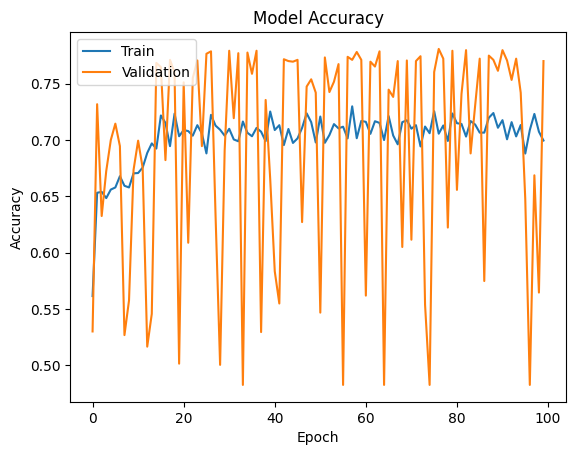

In [144]:
# apply Elastic Net to perform feature selection
en = ElasticNet(alpha=0.5, l1_ratio=0.5)
en.fit(X_train, y_train)
selected_features = X_train.columns[en.coef_ != 0]

# create a new dataframe with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print('Number fo Selected Features:', X_train_selected.shape)

# train a Sequential model on the selected features
model = Sequential()
model.add(Dense(16, input_dim=X_train_selected.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
start_time = time.time()
history = model.fit(X_train_selected, y_train, epochs=100, batch_size=32, validation_data=(X_test_selected, y_test))
end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

# evaluate the model on the testing set
y_pred = model.predict(X_test_selected)
y_pred = [1 if val > 0.5 else 0 for val in y_pred]
report = classification_report(y_test, y_pred)
print(report)

acc = accuracy_score(y_test, y_pred)

# plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Experiment4**
**Compare Experiment 1 with ->** **First apply GA, then Elastic Net in second layer to analyse the performance of model**

(7424, 29)
(1856, 29)
(7424, 1)
(1856, 1)
Number fo Selected Features: (7424, 3)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


232/232 [==============================] - 1s 3ms/step - loss: 4.1909 - accuracy: 0.7439 - val_loss: 0.9241 - val_accuracy: 0.6002
Epoch 2/100
232/232 [==============================] - 0s 2ms/step - loss: 0.7900 - accuracy: 0.7213 - val_loss: 0.5758 - val_accuracy: 0.7667
Epoch 3/100
232/232 [==============================] - 1s 2ms/step - loss: 0.7559 - accuracy: 0.7252 - val_loss: 0.5202 - val_accuracy: 0.7726
Epoch 4/100
232/232 [==============================] - 1s 3ms/step - loss: 0.7201 - accuracy: 0.7264 - val_loss: 0.7029 - val_accuracy: 0.7624
Epoch 5/100
232/232 [==============================] - 1s 3ms/step - loss: 0.7870 - accuracy: 0.7166 - val_loss: 0.6542 - val_accuracy: 0.7495
Epoch 6/100
232/232 [==============================] - 1s 3ms/step - loss: 0.8100 - accuracy: 0.7111 - val_loss: 0.8769 - val_accuracy: 0.7053
Epoch 7/100
232/232 [==============================] - 0s 2ms/step - loss: 0.7248 - accuracy: 0.7289 - val_loss: 0.5203 - val_accuracy: 0.7753
Epoch 8/100

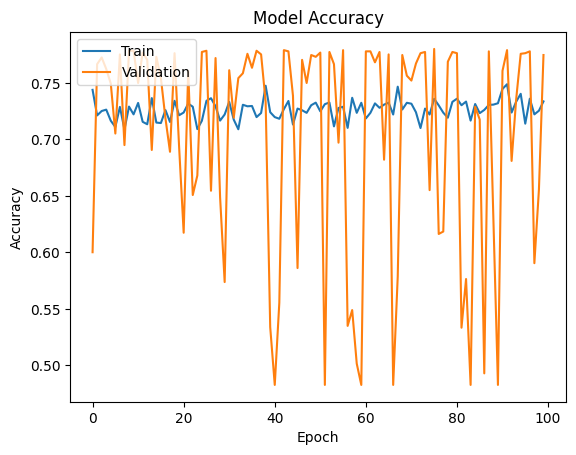

In [153]:


# split the data into training and testing sets
X_train, X_test, y_train, y_test = generate_dataframes_for_training(optimized_dataframe)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# apply Elastic Net to perform feature selection
en = ElasticNet(alpha=0.5, l1_ratio=0.5)
en.fit(X_train, y_train)
selected_features = X_train.columns[en.coef_ != 0]

# create a new dataframe with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print('Number fo Selected Features:', X_train_selected.shape)

# train a Sequential model on the selected features
model = Sequential()
model.add(Dense(16, input_dim=X_train_selected.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
start_time = time.time()
history = model.fit(X_train_selected, y_train, epochs=100, batch_size=32, validation_data=(X_test_selected, y_test))
end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

# evaluate the model on the testing set
y_pred = model.predict(X_test_selected)
y_pred = [1 if val > 0.5 else 0 for val in y_pred]
report = classification_report(y_test, y_pred)
print(report)

acc = accuracy_score(y_test, y_pred)

# plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Experiment5**
**Compare Experiment 1 Results with PCA**

In [158]:
# Generate dataframes for both training and testing
X_train, X_test, y_train, y_test = generate_dataframes_for_training(dataframe)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define the sequential model
model = Sequential()
model.add(Dense(64, input_shape=(10,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


# Train the model
start_time = time.time()
history = model.fit(X_train_pca, y_train, validation_data=(X_test_pca, y_test), epochs=100, batch_size=32)
end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time, "seconds")




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(7424, 68)
(1856, 68)
(7424, 1)
(1856, 1)
Epoch 1/100
232/232 [==============================] - 1s 3ms/step - loss: 0.5852 - accuracy: 0.6985 - val_loss: 0.5491 - val_accuracy: 0.7338
Epoch 2/100
232/232 [==============================] - 1s 2ms/step - loss: 0.5617 - accuracy: 0.7162 - val_loss: 0.5444 - val_accuracy: 0.7403
Epoch 3/100
232/232 [==============================] - 0s 2ms/step - loss: 0.5566 - accuracy: 0.7190 - val_loss: 0.5411 - val_accuracy: 0.7446
Epoch 4/100
232/232 [==============================] - 1s 2ms/step - loss: 0.5548 - accuracy: 0.7213 - val_loss: 0.5386 - val_accuracy: 0.7495
Epoch 5/100
232/232 [==============================] - 1s 2ms/step - loss: 0.5510 - accuracy: 0.7237 - val_loss: 0.5395 - val_accuracy: 0.7489
Epoch 6/100
232/232 [==============================] - 0s 2ms/step - loss: 0.5489 - accuracy: 0.7223 - val_loss: 0.5388 - val_accuracy: 0.7462
Epoch 7/100
232/232 [==============================] - 1s 2ms/step - loss: 0.5476 - accuracy: 0.7276

ValueError: ignored

In [163]:
y_pred = model.predict(X_test_pca)
y_pred = [1 if val > 0.5 else 0 for val in y_pred]

print(classification_report(y_test, y_pred))

58/58 [==============================] - 0s 1ms/step
[0 0 0 ... 1 1 1]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0

# **Experiment6**
**Compare Experiment 1 Results with Genetic algorithm with logistic regression**

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import time

# Generate dataframes for both training and testing
X_train, X_test, y_train, y_test = generate_dataframes_for_training(optimized_dataframe)

# Train the logistic regression model
start_time = time.time()
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time)

# Calculate the accuracy of the model on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print the number of features used
num_features = sum(clf.coef_.ravel() != 0)
print('Number of features used:', num_features)

# Print the training time
training_time = end_time - start_time
print('Training Time:', training_time, 'seconds')




(7424, 29)
(1856, 29)
(7424, 1)
(1856, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: 0.2034904956817627
Classification Report:
              precision    recall  f1-score   support

          no       0.90      0.85      0.88       960
         yes       0.85      0.90      0.88       896

    accuracy                           0.88      1856
   macro avg       0.88      0.88      0.88      1856
weighted avg       0.88      0.88      0.88      1856

Number of features used: 29
Training Time: 0.2034904956817627 seconds


# **Experiment7**
**Compare Experiment 1 Results with Random Forest**

(7424, 68)
(1856, 68)
(7424, 1)
(1856, 1)


<ipython-input-175-b58c8b1e6205>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


Training time: 1.4192256927490234
Accuracy: 0.8954741379310345


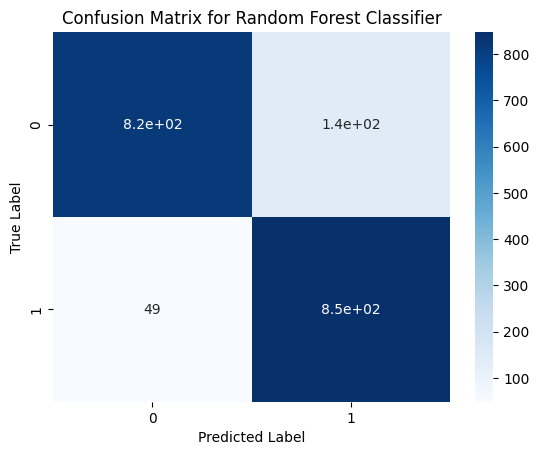

Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.85      0.89       960
         yes       0.85      0.95      0.90       896

    accuracy                           0.90      1856
   macro avg       0.90      0.90      0.90      1856
weighted avg       0.90      0.90      0.90      1856

Feature Importances: [3.33868077e-02 3.18071360e-01 1.57010452e-02 1.72566120e-02
 9.36177311e-03 5.84761318e-02 2.38589691e-02 3.12460092e-02
 6.82922190e-02 5.20034812e-02 3.29237335e-02 3.36926483e-02
 3.33499078e-02 3.25083021e-02 3.46115636e-02 5.05900075e-03
 4.98910005e-03 1.78805951e-03 1.56135184e-03 3.16506016e-03
 3.15617213e-03 2.00519119e-03 3.32952922e-03 2.28273156e-03
 3.91219237e-03 1.52153691e-03 8.13278822e-04 3.36221713e-03
 5.05817643e-03 5.10039970e-03 3.31998013e-04 2.67381934e-03
 2.12057945e-03 4.51623815e-03 4.89320520e-03 6.07839298e-05
 3.35796338e-03 5.90232843e-03 2.07013898e-03 5.89365743e-03
 4.24582421e-03 0.

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate dataframes for both training and testing
X_train, X_test, y_train, y_test = generate_dataframes_for_training(dataframe)

# Create the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


start_time = time.time()

# Train the model
rf_model.fit(X_train, y_train)


end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time)



# Test the model
y_pred = rf_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate the precision, recall, and f1-score
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Get the feature importances
importances = rf_model.feature_importances_
print("Feature Importances:", importances)

# Get the number of features
num_features = X_train.shape[1]
print("Number of Features:", num_features)
